# BB84 QKD Parameters Optimization

## Fiber Lengths and n_X Values
Fiber lengths are created from 0 to 200 km in 0.1 km steps, resulting in 2001 unique fiber lengths. \
$n_X$ values are used ranging from $10^6$ to $10^{10}$, creating 5 unique values. \
Form all combinations of fiber lengths and $n_X$, resulting in 2001 $\times$ 5 = 10,005 combinations, which aligns with the aim to generate a large dataset.

## Optimization Process:
For each combination of fiber length $L$ and $n_X$, The parameters $\vec{p}$ = $ [ \mu_1, \mu_2, P_{\mu_1}, P_{\mu_2}, P_X ]$ are optimized using dual_annealing, which is a global optimization algorithm. \
The objective function is wrapped to evaluate the key rate for a specific combination of fiber length and $n_X$. 

## Parallelization:
joblib’s Parallel is used to run the optimization for all combinations in parallel, with 12 threads, making the process efficient. \
tqdm-joblib is also used to track progress visually. 

## Dataset Creation:
The results of the optimization ($e_1, e_2, e_3, e_4, n_X, R, p_{opt}$) are collected into a dataset. \
This dataset is saved to a file (training_dataset.json) for training a neural network. 




## Setup

### Framework Selection:JAX
Functional Programming: Simplify scientific computation and optimization workflows. \
Smaller Footprint: Ideal if the project doesn’t leverage TensorFlow’s broader ecosystem.

##### Key Considerations
For numerically intensive workloads (e.g., optimization tasks like QKD key rate calculations), JAX excels due to its lightweight functional paradigm.

##### Conclusion
Use JAX for performance-critical, purely numerical optimization tasks with minimal dependencies on machine learning frameworks.

## Imports

In [1]:
# Import necessary libraries
import os
import sys
import time
import json
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict
from scipy.optimize import minimize, dual_annealing, differential_evolution, Bounds

# JAX imports
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp, gamma
from jax.experimental import pjit
from jax.sharding import Mesh

# SciPy imports
from math import exp, factorial

# JAX configuration for double precision
jax.config.update("jax_enable_x64", True)

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
print(jax.devices())

[CpuDevice(id=0)]


In [ ]:
# pip install jax --upgrade s

## Experimental Parameters

In [ ]:
# e_1
# Fiber lengths
Ls = jnp.linspace(1e-12, 200, 200)  # Fiber lengths in km
L_BC = Ls
e_1 = L_BC / 100
    
#e_2
P_dc_value = 6*10**-7  # Dark count probability
Y_0 = P_dc_value
# 2.7*10** -7
# P_dc = 6 * 10 ** (-7)   # given in the paper, discussed with range from 10^-8 to 10^-5
e_2 = -jnp.log(Y_0)

# e_3
e_mis = 5 * 10 ** -3  # Misalignment error probability
# 0.026 
e_d = e_mis
e_3 = e_d * 100
e_mis = 5*1e-3 # given in the paper, discussed with range from 0 to 0.1 

# e_4
# Detected events
n_X_values = [10**9] #[10 ** s for s in range(4, 11)]  # Detected events
# n_X_values = jnp.array([10**s for s in range(6, 11)], dtype=jnp.int64)
N = jnp.array(n_X_values)
e_4 = jnp.log(N)

## Other Parameters

In [ ]:
# alpha = 0.2  # Attenuation coefficient (dB/km), given in the paper
# eta_Bob = 0.1  # Detector efficiency, given in the paper
# P_ap = 0  # After-pulse probability
# f_EC = 1.16  # Error correction efficiency
# # secutity error 
# epsilon_sec = 1e-10 # is equal to kappa * secrecy length Kl, range around 1e-10 Scalar, as it is a single value throughout the calculations.
# # correlation error
# epsilon_cor = 1e-15 # given in the paper, discussed with range from 0 to 10e-10
# # Dark count probability
# n_event = 1  # for single photon event
# # Misalignment error probability
# # 4*1e-2          # given in the paper, discussed with range from 0 to 0.1
# kappa = 1e-15           # given in the paper
# f_EC = 1.16             # given in the paper, range around 1.1


## Optimal Paramters

In [ ]:
def optimal_parameters(params):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = params
    mu_3 = 2e-4
    P_mu_3 = 1 - P_mu_1 - P_mu_2
    P_Z_value = 1 - P_X_value
    mu_k_values = jnp.array([mu_1, mu_2, mu_3])
    return params, mu_3, P_mu_3, P_Z_value, mu_k_values

## Functions

The calculate_factorial function provided uses the gamma function to compute the factorial of a number  n . This is mathematically correct because the gamma function  \Gamma(n+1)  is equivalent to the factorial  n!  for non-negative integers  n .

## Mathematical Background
The gamma function is defined as:
$\Gamma(x) = \int_0^\infty t^{x-1} e^{-t} \, dt$ \
For positive integers, the gamma function satisfies the relationship: \
$\Gamma(n + 1) = n!$
\
JAX does not have a built-in factorial function, but it does support the gamma function. This makes the approach valid and compatible with JAX for automatic differentiation and JIT compilation.

In [ ]:
from QKD_Functions import (
calculate_factorial,
calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
)

In [ ]:
# Initialize dataset storage
categorized_dataset = {n_X: [] for n_X in n_X_values}

# # Initial guess and bounds
# initial_guess = np.array([0.325684, 0.008542, 0.601268, 0.810905, 0.681594])


In [ ]:
import numpy as np
from scipy.optimize import dual_annealing, minimize
from tqdm import tqdm
import concurrent.futures
import logging
import json
import time
import json
import time
import numpy as np
import concurrent.futures

In [ ]:
# # Global variables
# x0 = initial_guess.copy()  # Store the last used initial guess
# last_valid_x0 = initial_guess.copy()  # Store the last valid parameters

In [ ]:
# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
# --- Optimization Setup ---
def setup_optimization():
    bounds = [(4e-4, 0.9), (2e-4, 0.5), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12)]
    initial_guess = np.array([0.55, 0.34, 0.15, 0.75, 0.75])
    # 1e4 initial_guess = np.array([0.65, 0.15, 0.05, 0.61, 0.425])
    # 1e5 initial_guess = np.array([0.62, 0.24, 0.10, 0.70, 0.55])
    # 1e6 initial_guess = np.array([0.68, 0.30, 0.14, 0.74, 0.66])
    # 1e7 initial_guess = np.array([0.55, 0.34, 0.15, 0.75, 0.75])
    L_values = np.linspace(0, 200, 1000)  # 100 entries
    n_X_values = [1e7]  # Detected events
    
    # Optimization parameters
    alpha = 0.2
    eta_Bob = 0.1
    P_dc_opt = 6e-7  # Used in optimization (matches P_dc_value)
    epsilon_sec = 1e-10
    epsilon_cor = 1e-15
    f_EC = 1.16
    e_mis_opt = 0.01  # Used in optimization (differs from e_mis in processing)
    P_ap = 0  # 4e-2
    n_event = 1
    # Global variables
    
    return (bounds, initial_guess, L_values, n_X_values, 
            alpha, eta_Bob, P_dc_opt, epsilon_sec, epsilon_cor, f_EC, e_mis_opt, P_ap, n_event)

In [ ]:
initial_guess = np.array([0.55, 0.34, 0.15, 0.75, 0.75])
x0 = initial_guess.copy()  # Store the last used initial guess
last_valid_x0 = initial_guess.copy()  # Store the last valid parameters

In [ ]:
def optimize_single_instance(L, n_X, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
    """Optimize key rate for a given fiber length L and fixed n_X."""
    global x0, last_valid_x0
    print(f"\n--- [DEBUG] Starting optimization for L={L} km ---")

    try:
        def wrapped_objective(params):
            key_rate = objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]
            return -max(0, key_rate)

        print(f"🔵 Initial Guess for L={L}: {x0}")

        # Global optimization
        global_result = dual_annealing(
            func=wrapped_objective,
            bounds=bounds,
            initial_temp=20,
            restart_temp_ratio=1e-8,
            visit=2.0,
            accept=-15.0,
            x0=x0
        )

        # Local refinement
        local_result = minimize(
            fun=wrapped_objective,
            x0=global_result.x,
            method='Nelder-Mead',
            options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}
        )

        optimized_params = local_result.x
        optimized_params = np.clip(optimized_params,
                                   [b[0] for b in bounds],
                                   [b[1] for b in bounds])
        optimized_key_rate = -local_result.fun

        print(f"✅ Final Optimized Parameters for L={L} km: {optimized_params}")
        print(f"✅ Final Optimized Key Rate for L={L} km: {optimized_key_rate}")

        # Check if parameters are within bounds
        out_of_bounds_flags = [param < b[0] or param > b[1] for param, b in zip(optimized_params, bounds)]
        out_of_bounds = any(out_of_bounds_flags)

        # Update x0 with the latest optimized parameters, regardless of bounds
        x0 = optimized_params.copy()

        if not out_of_bounds:
            # If parameters are within bounds, update last_valid_x0
            last_valid_x0 = optimized_params.copy()
            return L, n_X, optimized_key_rate, optimized_params, optimized_params.copy()
        else:
            print(f"⚠️ Parameters out of bounds for L={L} km, reverting to last valid parameters.")
            # If parameters are out of bounds, revert to last_valid_x0
            x0 = last_valid_x0.copy()
            return L, n_X, optimized_key_rate, optimized_params, x0

    except Exception as e:
        print(f"❌ Error at L={L}: {e}")
        # If an error occurs, revert to last_valid_x0
        x0 = last_valid_x0.copy()
        return L, n_X, float('nan'), [float('nan')] * len(bounds), x0
 

In [ ]:
# def optimize_single_instance(L, n_X, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
#     """Optimize key rate for a given fiber length L and fixed n_X."""
#     global x0, last_valid_x0
#     print(f"\n--- [DEBUG] Starting optimization for L={L} km ---")

#     try:
#         def wrapped_objective(params):
#             key_rate = objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]
#             return  -max(0, key_rate)

#         print(f"🔵 Initial Guess for L={L}: {x0}")

#         # Global optimization
#         # Perform global optimization
#         global_result = dual_annealing(
#             func=wrapped_objective,
#             bounds=bounds,
#             initial_temp=20,  
#             restart_temp_ratio=1e-8,  
#             visit=2.0,  
#             accept=-15.0,
#             x0=x0
#         )
#         # Local refinement
#         local_result = minimize(
#             fun=wrapped_objective,
#             x0=global_result.x,
#             method='Nelder-Mead',
#             options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}
#         )

#         optimized_params = local_result.x
#         optimized_params = np.clip(optimized_params,  
#                            [b[0] for b in bounds], 
#                            [b[1] for b in bounds])
#         optimized_key_rate = -local_result.fun

#         print(f"✅ Final Optimized Parameters for L={L} km: {optimized_params}")
#         print(f"✅ Final Optimized Key Rate for L={L} km: {optimized_key_rate}")

#         # Update x0 with the latest optimized parameters
#         x0 = optimized_params.copy()

#         # Check if parameters are within bounds
#         out_of_bounds_flags = [param < b[0] or param > b[1] for param, b in zip(optimized_params, bounds)]
#         out_of_bounds = any(out_of_bounds_flags)  

#         if not out_of_bounds:
#             return L, n_X, optimized_key_rate, optimized_params, optimized_params.copy()  
#         else:
#             print(f"⚠️ Parameters out of bounds for L={L} km, but keeping best parameters seen so far.")
#             return L, n_X, optimized_key_rate, optimized_params, x0  

#     except Exception as e:
#         print(f"❌ Error at L={L}: {e}")
#         return L, n_X, float('nan'), [float('nan')] * len(bounds), x0

In [ ]:
def submit_in_batches(executor, L_values, n_X_values, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, batch_size=16 ):
    all_results = []
    tasks = [(L, n_X) for L in L_values for n_X in n_X_values]
    total = len(tasks)
    with tqdm(total=total, desc="Optimizing") as pbar:
        for i in range(0, total, batch_size):
            batch = tasks[i:i + batch_size]
            futures = [executor.submit(optimize_single_instance, L, n_X, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event) for L, n_X in batch]
            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                all_results.append(result)
                pbar.update(1)
    return all_results

In [ ]:
# --- Configuration ---
P_dc_value = 6e-7  # Dark count probability (used in processing)
e_mis = 5e-3      # Misalignment error (used in processing)
output_dir = "../../Training_Data/single_nx/"
timestamp = time.strftime("%Y%m%d_%H%M%S")

In [ ]:
import json
import matplotlib.pyplot as plt  # Assuming you're using matplotlib for plotting

# --- Main Execution ---
def plot_for_nx(dataset, n_X):
    # Example plotting function (customize as needed)
    fiber_lengths = [entry['fiber_length'] for entry in dataset.get(str(n_X), [])]
    some_metric = [entry.get('some_metric', 0) for entry in dataset.get(str(n_X), [])]  # Replace 'some_metric' with actual key
    plt.plot(fiber_lengths, some_metric, label=f'n_X = {n_X:.0e}')
    plt.xlabel('Fiber Length (km)')
    plt.ylabel('Some Metric')
    plt.title(f'Plot for n_X = {n_X:.0e}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# --- Step 1: Generate Initial Dataset ---
def create_initial_dataset(all_results_sorted):
    dataset = []
    for L, n_X, key_rate, params, init_guess in all_results_sorted:
        dataset.append({
            "fiber_length": float(L),
            "n_X": int(n_X),
            "key_rate": float(key_rate),
            "optimized_parameters": {
                "mu_1": float(params[0]),
                "mu_2": float(params[1]),
                "P_mu_1": float(params[2]),
                "P_mu_2": float(params[3]),
                "P_X_value": float(params[4]),
            },
            "initial_guess": {
                "mu_1": float(init_guess[0]),
                "mu_2": float(init_guess[1]),
                "P_mu_1": float(init_guess[2]),
                "P_mu_2": float(init_guess[3]),
                "P_X_value": float(init_guess[4]),
            }
        })
    return dataset

In [ ]:
# --- Step 2: Process and Group Dataset ---
def process_and_group_dataset(dataset):
    grouped_data = {}
    for entry in dataset:
        fiber_length = entry["fiber_length"]
        n_X = float(entry["n_X"])

        # Compute additional features
        e_1 = fiber_length / 100           # Normalized fiber length
        e_2 = -np.log10(P_dc_value)        # Dark count processing
        e_3 = e_mis * 100                  # Misalignment error
        e_4 = np.log10(n_X)                # Log-transformed detected events

        # Format entry
        formatted_entry = {
            "fiber_length": fiber_length,
            "e_1": e_1,
            "e_2": e_2,
            "e_3": e_3,
            "e_4": e_4,
            "key_rate": entry["key_rate"],
            "optimized_params": entry["optimized_parameters"],
        }

        # Group by n_X
        n_X_str = str(n_X)
        if n_X_str not in grouped_data:
            grouped_data[n_X_str] = []
        grouped_data[n_X_str].append(formatted_entry)
    
    return grouped_data

In [ ]:
# --- Step 3: Reorder by Fiber Length ---
def reorder_by_fiber_length(grouped_data):
    for key, data_list in grouped_data.items():
        if not all(isinstance(item, dict) and "fiber_length" in item for item in data_list):
            raise ValueError(f"Invalid data format in group {key}")
        grouped_data[key] = sorted(data_list, key=lambda x: x["fiber_length"])
    return grouped_data

In [ ]:
import json
import numpy as np
import concurrent.futures

# --- Main Execution ---
def main():
    try:
        # Step 1: Run optimization
        (bounds, initial_guess, L_values, n_X_values, alpha, eta_Bob, 
         P_dc_opt, epsilon_sec, epsilon_cor, f_EC, e_mis_opt, P_ap, n_event) = setup_optimization()
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            all_results_sorted = submit_in_batches(
                executor, L_values, n_X_values, bounds, initial_guess, 
                alpha, eta_Bob, P_dc_opt, epsilon_sec, epsilon_cor, f_EC, e_mis_opt, P_ap, n_event
            )

        # Step 2: Generate initial dataset
        dataset = create_initial_dataset(all_results_sorted)

        # Generalized formatting for n_X
        def format_n_X(n_X):
            # Convert to float if it's in scientific notation
            n_X_float = float(n_X)
            
            # Determine the exponent
            exponent = int(np.floor(np.log10(n_X_float)))
            
            # Determine the base
            base = n_X_float / (10 ** exponent)
            
            # Format the string as "base_exponent"
            n_X_str = f"{int(base)}_{exponent}"
            return n_X_str

        # Format n_X for filename (e.g., 1e4 -> "10_4")
        n_X_str = format_n_X(n_X_values[0])  # Assumes n_X is in the form 1eX
        total_entries = len(dataset)
        
        # Save initial dataset with n_X and total entries in filename
        initial_filename = f"{output_dir}{n_X_str}_{total_entries}_qkd_optimization_results_{timestamp}.json"
        with open(initial_filename, 'w') as f:
            json.dump(dataset, f, indent=2)
        print(f"\n✅ Initial dataset saved as: {initial_filename}")
        
        # Initial dataset summary
        print("\n📊 **Initial Dataset Summary** 📊")
        print(f"Total Entries: {total_entries}")
        print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
        print(f"n_X Values: {', '.join(map(str, n_X_values))}")
        print("=" * 100)

        # Step 3: Process and group
        grouped_data = process_and_group_dataset(dataset)
        
        # Step 4: Reorder by fiber length
        reordered_data = reorder_by_fiber_length(grouped_data)
        
        # Step 5: Save final dataset with n_X and total entries in filename
        final_filename = f"{output_dir}{n_X_str}_{total_entries}_reordered_qkd_grouped_dataset_{timestamp}.json"
        with open(final_filename, 'w') as f:
            json.dump(reordered_data, f, indent=2)
        print(f"\n✅ Final reordered dataset saved as: {final_filename}")
        
        # Final dataset summary
        print("\n📊 **Final Dataset Summary** 📊")
        for n_X_key, entries in reordered_data.items():
            print(f"n_X = {n_X_key}: {len(entries)} entries")
            print(f"Sample Entry:\n{json.dumps(entries[0], indent=2)}\n")

    except Exception as e:
        print(f"Error during processing: {e}")


In [ ]:
# --- Run the Script ---
if __name__ == "__main__":
    # Assuming submit_in_batches is defined elsewhere
    main()

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_for_nx(data, target_nx):
    """
    Plot results for a specific n_X value, filtering out zero key rates.
    """
    # Convert to string for dictionary key lookup
    target_nx_str = str(float(target_nx))  # Ensure it matches JSON key format

    # Retrieve data correctly from grouped dictionary
    if target_nx_str not in data:
        print(f"No data found for n_X = {target_nx}")
        return
    
    filtered_data = data[target_nx_str]  # Get the list of entries
    
    # Filter out key rates that are zero or too small
    filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-100]  # Adjust threshold if needed

    if not filtered_data:
        print(f"No non-zero key rates found for n_X = {target_nx}")
        return

    # Extract data
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]

    # ✅ Improved visualization
    plt.figure(figsize=(12, 6))
    
    # ✅ Key Rate vs Fiber Length
    plt.subplot(1, 2, 1)
    plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', color='b', label="Key Rate")
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
    plt.legend()
    plt.grid(True)
    
    # ✅ Optimized Parameters vs Fiber Length
    plt.subplot(1, 2, 2)
    params_names = list(filtered_data[0]["optimized_params"].keys())
    for param_name in params_names:
        params_values = [entry["optimized_params"][param_name] for entry in filtered_data]
        plt.plot(fiber_lengths, params_values, linestyle='-', label=param_name)
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Parameter Value")
    plt.title(f"Optimized Parameters vs Fiber Length (n_X = {target_nx:.0e})")
    plt.legend()
    plt.ylim(0.0, 1.0)
    plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
    plt.show()

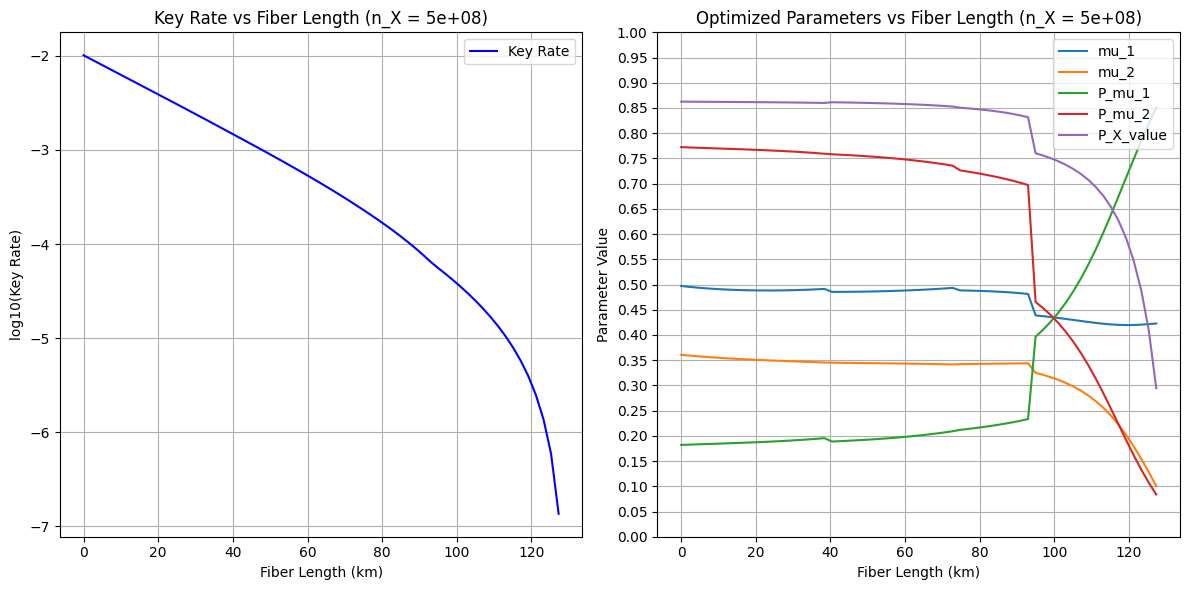

Available n_X values: ['500000000.0']

Plotting results for n_X = 1e+04
No data found for n_X = 10000

Plotting results for n_X = 1e+05
No data found for n_X = 100000

Plotting results for n_X = 1e+06
No data found for n_X = 1000000

Plotting results for n_X = 1e+07
No data found for n_X = 10000000

Plotting results for n_X = 1e+08
No data found for n_X = 100000000

Plotting results for n_X = 1e+09
No data found for n_X = 1000000000


In [22]:
# Load dataset
# with open("qkd_grouped_dataset_20250213_110036.json", 'r') as f:
#     dataset = json.load(f)
with open("../../Training_Data/single_nx/reordered_qkd_grouped_dataset_20250224_112957.json", 'r') as f:
    dataset = json.load(f)

plot_for_nx(dataset, 500000000)
# Print available n_X values
print("Available n_X values:", list(dataset.keys())[:5])  # Print first 5 unique n_X values

# List of n_X values to plot
n_X_values = [10**s for s in range(4, 10)]  # Generates [10^4, 10^5, ..., 10^9]

# Loop through n_X values and plot
for n_X in n_X_values:
    print(f"\nPlotting results for n_X = {n_X:.0e}")
    plot_for_nx(dataset, n_X)

Available n_X values: ['10000.0', '100000.0', '1000000.0', '10000000.0', '100000000.0', '1000000000.0']


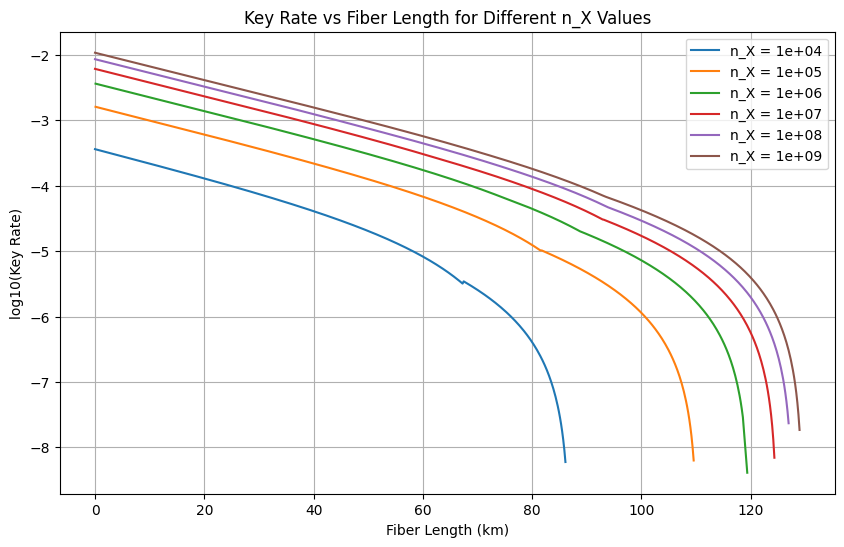

In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
with open("../../Training_Data/combined_datasets.json", 'r') as f:
    dataset = json.load(f)

# Print available keys (debugging)
print("Available n_X values:", list(dataset.keys()))  

# Define n_X values
n_X_values = [10**s for s in range(4, 10)]  # [10^4, 10^5, ..., 10^9]

# Initialize figure
plt.figure(figsize=(10, 6))

# Plot key rate vs fiber length for each n_X
for n_X in n_X_values:
    target_nx_str = str(float(n_X))  # Ensure correct format

    if target_nx_str not in dataset:
        print(f"❌ No data found for n_X = {n_X}")
        continue

    filtered_data = dataset[target_nx_str]
    filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-30]  

    if not filtered_data:
        print(f"⚠️ No non-zero key rates for n_X = {n_X}")
        continue

    # Extract fiber lengths and key rates
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]

    # Plot with unique colors and dashed lines
    plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', label=f"n_X = {n_X:.0e}")

# Graph formatting
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Key Rate)")
plt.title("Key Rate vs Fiber Length for Different n_X Values")
plt.legend()
plt.grid(True)

# Save and show plot
plt.savefig("key_rate_vs_fiber_length.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# import json
# import time
# import numpy as np
# import concurrent.futures

# # --- Configuration ---
# P_dc_value = 6e-7  # Dark count probability (used in processing)
# e_mis = 5e-3      # Misalignment error (used in processing)
# output_dir = "../../Training_Data/single_nx/"
# timestamp = time.strftime("%Y%m%d_%H%M%S")

# # --- Optimization Setup ---
# def setup_optimization():
#     bounds = [(4e-4, 0.9), (2e-4, 0.5), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12)]
#     initial_guess = np.array([0.65, 0.15, 0.05, 0.61, 0.425])
#     L_values = np.linspace(1e-1, 200, 100)
#     n_X_values = [1e4]  # Detected events
    
#     # Optimization parameters
#     alpha = 0.2
#     eta_Bob = 0.1
#     P_dc_opt = 6e-7  # Used in optimization (matches P_dc_value)
#     epsilon_sec = 1e-10
#     epsilon_cor = 1e-15
#     f_EC = 1.16
#     e_mis_opt = 0.01  # Used in optimization (differs from e_mis in processing)
#     P_ap = 0  # 4e-2
#     n_event = 1
    
#     return (bounds, initial_guess, L_values, n_X_values, 
#             alpha, eta_Bob, P_dc_opt, epsilon_sec, epsilon_cor, f_EC, e_mis_opt, P_ap, n_event)

# # --- Step 1: Generate Initial Dataset ---
# def create_initial_dataset(all_results_sorted):
#     dataset = []
#     for L, n_X, key_rate, params, init_guess in all_results_sorted:
#         dataset.append({
#             "fiber_length": float(L),
#             "n_X": int(n_X),
#             "key_rate": float(key_rate),
#             "optimized_parameters": {
#                 "mu_1": float(params[0]),
#                 "mu_2": float(params[1]),
#                 "P_mu_1": float(params[2]),
#                 "P_mu_2": float(params[3]),
#                 "P_X_value": float(params[4]),
#             },
#             "initial_guess": {
#                 "mu_1": float(init_guess[0]),
#                 "mu_2": float(init_guess[1]),
#                 "P_mu_1": float(init_guess[2]),
#                 "P_mu_2": float(init_guess[3]),
#                 "P_X_value": float(init_guess[4]),
#             }
#         })
#     return dataset

# # --- Step 2: Process and Group Dataset ---
# def process_and_group_dataset(dataset):
#     grouped_data = {}
#     for entry in dataset:
#         fiber_length = entry["fiber_length"]
#         n_X = float(entry["n_X"])

#         # Compute additional features
#         e_1 = fiber_length / 100           # Normalized fiber length
#         e_2 = -np.log10(P_dc_value)        # Dark count processing
#         e_3 = e_mis * 100                  # Misalignment error
#         e_4 = np.log10(n_X)                # Log-transformed detected events

#         # Format entry
#         formatted_entry = {
#             "fiber_length": fiber_length,
#             "e_1": e_1,
#             "e_2": e_2,
#             "e_3": e_3,
#             "e_4": e_4,
#             "key_rate": entry["key_rate"],
#             "optimized_params": entry["optimized_parameters"],
#         }

#         # Group by n_X
#         n_X_str = str(n_X)
#         if n_X_str not in grouped_data:
#             grouped_data[n_X_str] = []
#         grouped_data[n_X_str].append(formatted_entry)
    
#     return grouped_data

# # --- Step 3: Reorder by Fiber Length ---
# def reorder_by_fiber_length(grouped_data):
#     for key, data_list in grouped_data.items():
#         if not all(isinstance(item, dict) and "fiber_length" in item for item in data_list):
#             raise ValueError(f"Invalid data format in group {key}")
#         grouped_data[key] = sorted(data_list, key=lambda x: x["fiber_length"])
#     return grouped_data

# # --- Main Execution ---
# def main():
#     try:
#         # Step 1: Run optimization
#         (bounds, initial_guess, L_values, n_X_values, alpha, eta_Bob, 
#          P_dc_opt, epsilon_sec, epsilon_cor, f_EC, e_mis_opt, P_ap, n_event) = setup_optimization()
        
#         with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#             all_results_sorted = submit_in_batches(
#                 executor, L_values, n_X_values, bounds, initial_guess, 
#                 alpha, eta_Bob, P_dc_opt, epsilon_sec, epsilon_cor, f_EC, e_mis_opt, P_ap, n_event
#             )

#         # Step 2: Generate initial dataset
#         dataset = create_initial_dataset(all_results_sorted)
#         initial_filename = f"{output_dir}qkd_optimization_results_{timestamp}.json"
#         with open(initial_filename, 'w') as f:
#             json.dump(dataset, f, indent=2)
#         print(f"\n✅ Initial dataset saved as: {initial_filename}")
        
#         # Initial dataset summary
#         print("\n📊 **Initial Dataset Summary** 📊")
#         print(f"Total Entries: {len(dataset)}")
#         print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
#         print(f"n_X Values: {', '.join(map(str, n_X_values))}")
#         print("=" * 100)

#         # Step 3: Process and group
#         grouped_data = process_and_group_dataset(dataset)
        
#         # Step 4: Reorder by fiber length
#         reordered_data = reorder_by_fiber_length(grouped_data)
        
#         # Step 5: Save final dataset
#         final_filename = f"{output_dir}reordered_qkd_grouped_dataset_{timestamp}.json"
#         with open(final_filename, 'w') as f:
#             json.dump(reordered_data, f, indent=2)
#         print(f"\n✅ Final reordered dataset saved as: {final_filename}")
        
#         # Final dataset summary
#         print("\n📊 **Final Dataset Summary** 📊")
#         for n_X_key, entries in reordered_data.items():
#             print(f"n_X = {n_X_key}: {len(entries)} entries")
#             print(f"Sample Entry:\n{json.dumps(entries[0], indent=2)}\n")
    
#     except Exception as e:
#         print(f"Error during processing: {e}")

# # --- Run the Script ---
# if __name__ == "__main__":
#     # Assuming submit_in_batches is defined elsewhere
#     main()

In [ ]:
# if __name__ == '__main__':
#     # Define constants and bounds
#     bounds = [(4e-4, 0.9), (2e-4, 0.5), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12)]
#     initial_guess = np.array([0.65, 0.15, 0.05, 0.61, 0.425])
#     L_values = np.linspace(1e-1, 200, 1000)
#     n_X_values = [1e4]  # Detected events

#     # Optimization parameters
#     alpha = 0.2
#     eta_Bob = 0.1
#     P_dc_value = 6*10**-7
#     epsilon_sec = 1e-10
#     epsilon_cor = 1e-15
#     f_EC = 1.16
#     e_mis = 0.01
#     P_ap = 0 # 4e-2
#     n_event = 1 

#     # Run optimization using ThreadPoolExecutor
#     with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#         all_results_sorted = submit_in_batches(executor, L_values, n_X_values, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)

#     # Generate and save dataset
#     dataset = [{
#         "fiber_length": float(L),
#         "n_X": int(n_X),
#         "key_rate": float(key_rate),
#         "optimized_parameters": { "mu_1": float(params[0]), "mu_2": float(params[1]), "P_mu_1": float(params[2]), "P_mu_2": float(params[3]), "P_X_value": float(params[4]) },
#         "initial_guess": { "mu_1": float(init_guess[0]), "mu_2": float(init_guess[1]), "P_mu_1": float(init_guess[2]), "P_mu_2": float(init_guess[3]), "P_X_value": float(init_guess[4]) }
#     } for L, n_X, key_rate, params, init_guess in all_results_sorted]

#     timestamp = time.strftime("%Y%m%d_%H%M%S")
#     filename = f'qkd_optimization_results_{timestamp}.json'
#     with open(filename, 'w') as f:
#         json.dump(dataset, f, indent=2)

#     # Print dataset summary
#     print("\nDataset Summary:")
#     print(f"Total Entries: {len(dataset)}")
#     print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
#     print(f"n_X Values: {', '.join(map(str, n_X_values))}")

In [ ]:
# import json
# import time
# import numpy as np

# # --- Configuration ---
# P_dc_value = 6e-7  # Dark count probability
# e_mis = 5e-3      # Misalignment error
# output_dir = "../../Training_Data/single_nx/"
# timestamp = time.strftime("%Y%m%d_%H%M%S")

# # --- Step 1: Generate Initial Dataset ---
# def create_initial_dataset(all_results_sorted):
#     dataset = []
#     for L, n_X, key_rate, params, init_guess in all_results_sorted:
#         dataset.append({
#             "fiber_length": float(L),
#             "n_X": int(n_X),
#             "key_rate": float(key_rate),
#             "optimized_parameters": {
#                 "mu_1": float(params[0]),
#                 "mu_2": float(params[1]),
#                 "P_mu_1": float(params[2]),
#                 "P_mu_2": float(params[3]),
#                 "P_X_value": float(params[4]),
#             },
#             "initial_guess": {
#                 "mu_1": float(init_guess[0]),
#                 "mu_2": float(init_guess[1]),
#                 "P_mu_1": float(init_guess[2]),
#                 "P_mu_2": float(init_guess[3]),
#                 "P_X_value": float(init_guess[4]),
#             }
#         })
#     return dataset

# # --- Step 2: Process and Group Dataset ---
# def process_and_group_dataset(dataset):
#     grouped_data = {}
#     for entry in dataset:
#         fiber_length = entry["fiber_length"]
#         n_X = float(entry["n_X"])

#         # Compute additional features
#         e_1 = fiber_length / 100           # Normalized fiber length
#         e_2 = -np.log10(P_dc_value)        # Dark count processing
#         e_3 = e_mis * 100                  # Misalignment error
#         e_4 = np.log10(n_X)                # Log-transformed detected events

#         # Format entry
#         formatted_entry = {
#             "fiber_length": fiber_length,
#             "e_1": e_1,
#             "e_2": e_2,
#             "e_3": e_3,
#             "e_4": e_4,
#             "key_rate": entry["key_rate"],
#             "optimized_params": entry["optimized_parameters"],
#         }

#         # Group by n_X
#         n_X_str = str(n_X)
#         if n_X_str not in grouped_data:
#             grouped_data[n_X_str] = []
#         grouped_data[n_X_str].append(formatted_entry)
    
#     return grouped_data

# # --- Step 3: Reorder by Fiber Length ---
# def reorder_by_fiber_length(grouped_data):
#     for key, data_list in grouped_data.items():
#         if not all(isinstance(item, dict) and "fiber_length" in item for item in data_list):
#             raise ValueError(f"Invalid data format in group {key}")
#         grouped_data[key] = sorted(data_list, key=lambda x: x["fiber_length"])
#     return grouped_data

# # --- Main Execution ---
# def main(all_results_sorted, n_X_values):
#     try:
#         # Generate initial dataset
#         dataset = create_initial_dataset(all_results_sorted)
#         initial_filename = f"{output_dir}qkd_optimization_results_{timestamp}.json"
#         with open(initial_filename, 'w') as f:
#             json.dump(dataset, f, indent=2)
#         print(f"\n✅ Initial dataset saved as: {initial_filename}")
        
#         # Summary of initial dataset
#         print("\n📊 **Initial Dataset Summary** 📊")
#         print(f"Total Entries: {len(dataset)}")
#         print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
#         print(f"n_X Values: {', '.join(map(str, n_X_values))}")
#         print("=" * 100)

#         # Process and group
#         grouped_data = process_and_group_dataset(dataset)
        
#         # Reorder by fiber length
#         reordered_data = reorder_by_fiber_length(grouped_data)
        
#         # Save final dataset
#         final_filename = f"{output_dir}reordered_qkd_grouped_dataset_{timestamp}.json"
#         with open(final_filename, 'w') as f:
#             json.dump(reordered_data, f, indent=2)
#         print(f"\n✅ Final reordered dataset saved as: {final_filename}")
        
#         # Summary of final dataset
#         print("\n📊 **Final Dataset Summary** 📊")
#         for n_X_key, entries in reordered_data.items():
#             print(f"n_X = {n_X_key}: {len(entries)} entries")
#             print(f"Sample Entry:\n{json.dumps(entries[0], indent=2)}\n")
    
#     except Exception as e:
#         print(f"Error during processing: {e}")

# # --- Run the Script ---
# # Placeholder for all_results_sorted and n_X_values (replace with your actual data)
# # Example: all_results_sorted = [(10, 100, 0.01, [1, 2, 0.1, 0.2, 0.3], [1.1, 2.1, 0.11, 0.21, 0.31]), ...]
# # Example: n_X_values = [100, 200, 300]
# if __name__ == "__main__":
#     # Replace these with your actual data sources
#     all_results_sorted = []  # Your input data here
#     n_X_values = []          # Your n_X values here
#     if all_results_sorted and n_X_values:
#         main(all_results_sorted, n_X_values)
#     else:
#         print("Please provide all_results_sorted and n_X_values to run the script.")

In [ ]:
# # ✅ Prepare dataset dictionary
# dataset = []

# # ✅ Convert results into a structured format
# for L, n_X, key_rate, params, init_guess in all_results_sorted:
#     dataset.append({
#         "fiber_length": float(L),
#         "n_X": int(n_X),
#         "key_rate": float(key_rate),
#         "optimized_parameters": {
#             "mu_1": float(params[0]),
#             "mu_2": float(params[1]),
#             "P_mu_1": float(params[2]),
#             "P_mu_2": float(params[3]),
#             "P_X_value": float(params[4]),
#         },
#         "initial_guess": {
#             "mu_1": float(init_guess[0]),
#             "mu_2": float(init_guess[1]),
#             "P_mu_1": float(init_guess[2]),
#             "P_mu_2": float(init_guess[3]),
#             "P_X_value": float(init_guess[4]),
#         }
#     })

# # ✅ Save dataset to a JSON file with a timestamp
# timestamp = time.strftime("%Y%m%d_%H%M%S")
# filename = f'qkd_optimization_results_{timestamp}.json'
# with open(filename, 'w') as f:
#     json.dump(dataset, f, indent=2)

# print(f"\n✅ Dataset saved as: {filename}")

# # ✅ Print dataset summary
# print("\n📊 **Dataset Summary** 📊")
# print(f"Total Entries: {len(dataset)}")
# print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
# print(f"n_X Values: {', '.join(map(str, n_X_values))}")
# print("=" * 100)

In [ ]:
# import json
# import time
# import numpy as np

# # ✅ Load the original dataset
# with open("........json", "r") as f:
#     dataset = json.load(f)

# # ✅ Fixed parameters
# P_dc_value = 6e-7  # Dark count probability
# e_mis = 5e-3  # Misalignment error

# # ✅ Grouped dictionary structure
# grouped_data = {}

# for entry in dataset:
#     fiber_length = entry["fiber_length"]
#     n_X = float(entry["n_X"])  # Convert to float for consistency

#     # ✅ Compute missing feature values
#     e_1 = fiber_length / 100  # Normalize fiber length
#     e_2 = -np.log10(P_dc_value)  # Dark count processing
#     e_3 = e_mis * 100  # Misalignment error
#     e_4 = np.log10(n_X)  # Log-transformed detected events

#     # ✅ Format the new entry
#     formatted_entry = {
#         "fiber_length": fiber_length,
#         "e_1": e_1,
#         "e_2": e_2,
#         "e_3": e_3,
#         "e_4": e_4,
#         "key_rate": entry["key_rate"],
#         "optimized_params": entry["optimized_parameters"],  # Keep only optimized parameters
#     }

#     # ✅ Store entries under their respective `n_X` group
#     n_X_str = str(n_X)  # Convert to string for JSON keys
#     if n_X_str not in grouped_data:
#         grouped_data[n_X_str] = []
#     grouped_data[n_X_str].append(formatted_entry)

# # ✅ Save the formatted dataset with a timestamp
# timestamp = time.strftime("%Y%m%d_%H%M%S")
# filename = f'../../Training_Data/single_nx/qkd_grouped_dataset_{timestamp}.json'
# with open(filename, 'w') as f:
#     json.dump(grouped_data, f, indent=2)

# print(f"\n✅ Dataset saved as: {filename}")

# # ✅ Print dataset summary
# print("\n📊 **Dataset Summary** 📊")
# for n_X_key, entries in grouped_data.items():
#     print(f"n_X = {n_X_key}: {len(entries)} entries")
#     print(f"Sample Entry:\n{json.dumps(entries[0], indent=2)}\n")

In [ ]:
# import json

# def reorder_json_by_fiber_length(file_path):
#     """
#     Reorders the JSON data from a file based on the 'fiber_length'
#     field within the first list found in the dictionary.

#     Args:
#         file_path: The path to the JSON file.

#     Returns:
#         A new Python dictionary with the same structure as the input, but with the
#         first list found sorted by the 'fiber_length' value in ascending order.
#         Returns None if the input is not in the expected format or if no suitable
#         list is found, or if there's an error reading or parsing the file.
#     """

#     try:
#         with open(file_path, 'r') as f:
#             json_data = json.load(f)
#     except FileNotFoundError:
#         print(f"Error: File not found at path: {file_path}")
#         return None
#     except json.JSONDecodeError as e:
#         print(f"Error decoding JSON from file: {e}")
#         return None

#     if not isinstance(json_data, dict):
#         print("Error: Input must be a dictionary.")
#         return None

#     # Find the first list in the dictionary
#     data_list = None
#     target_key = None
#     for key, value in json_data.items():
#         if isinstance(value, list):
#             data_list = value
#             target_key = key
#             break  # Stop after finding the first list

#     if data_list is None:
#         print("Error: No list found in the dictionary.")
#         return None

#     # Validate the list elements
#     for item in data_list:
#         if not isinstance(item, dict) or "fiber_length" not in item:
#             print("Error: List elements must be dictionaries containing the key 'fiber_length'.")
#             return None

#     # Sort the list by 'fiber_length'
#     sorted_data_list = sorted(data_list, key=lambda x: x["fiber_length"])

#     # Create a new dictionary with the sorted list
#     reordered_json_data = json_data.copy() # Avoid modifying the original
#     reordered_json_data[target_key] = sorted_data_list

#     return reordered_json_data

In [ ]:
# file_path = '../../Training_Data/single_nx/.......json' # Replace with the actual file path
# reordered_data = reorder_json_by_fiber_length(file_path)

In [ ]:
# output_file_path = "../../Training_Data/single_nx/reordered_qkd_grouped_dataset_20250223_004018.json" # Choose a name for the output file
# with open(output_file_path, 'w') as outfile:
#     json.dump(reordered_data, outfile, indent=2)

In [ ]:
# import json
# import numpy as np
# import matplotlib.pyplot as plt

# # Load dataset
# with open("qkd_grouped_dataset_20250206_223840.json", 'r') as f:
#     dataset = json.load(f)

# # Print available keys (debugging)
# print("Available n_X values:", list(dataset.keys()))  

# # Define n_X values
# n_X_values = [10**s for s in range(4, 10)]  # [10^4, 10^5, ..., 10^9]

# # Initialize figure
# plt.figure(figsize=(10, 6))

# # Plot key rate vs fiber length for each n_X
# for n_X in n_X_values:
#     target_nx_str = str(float(n_X))  # Ensure correct format

#     if target_nx_str not in dataset:
#         print(f"❌ No data found for n_X = {n_X}")
#         continue

#     filtered_data = dataset[target_nx_str]
#     filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-30]  

#     if not filtered_data:
#         print(f"⚠️ No non-zero key rates for n_X = {n_X}")
#         continue

#     # Extract fiber lengths and key rates
#     fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
#     key_rates = [entry["key_rate"] for entry in filtered_data]

#     # Plot with unique colors and dashed lines
#     plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', label=f"n_X = {n_X:.0e}")

# # Graph formatting
# plt.xlabel("Fiber Length (km)")
# plt.ylabel("log10(Key Rate)")
# plt.title("Key Rate vs Fiber Length for Different n_X Values")
# plt.legend()
# plt.grid(True)

# # Save and show plot
# plt.savefig("key_rate_vs_fiber_length.png", dpi=300, bbox_inches="tight")
# plt.show()